# Testing separation method

In [ ]:
!pip install noisereduce

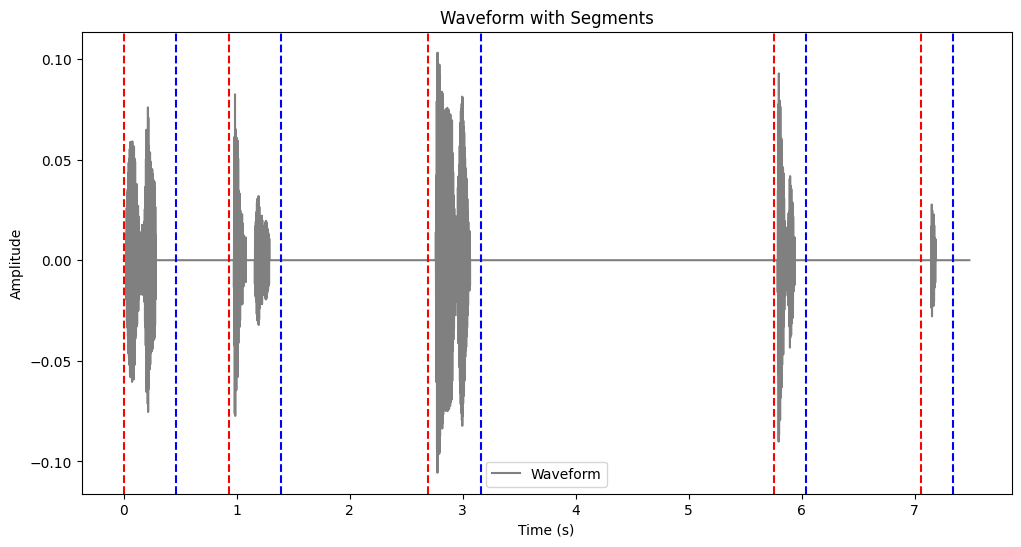

In [ ]:
import noisereduce as nr
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from IPython.display import Audio, display

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_segments(y, segments, threshold):
    filtered_segments = []
    for segment in segments:

        duration = (segment[1] - segment[0]) / sr
        if duration > 0.85:
            mid_point = (segment[0] + segment[1]) // 2
            segment1 = (segment[0], mid_point)
            segment2 = (mid_point, segment[1])

            max_amplitude1 = np.max(np.abs(y[segment1[0]:segment1[1]]))
            if max_amplitude1 > threshold:
                filtered_segments.append(segment1)

            max_amplitude2 = np.max(np.abs(y[segment2[0]:segment2[1]]))
            if max_amplitude2 > threshold:
                filtered_segments.append(segment2)
        else:
            max_amplitude = np.max(np.abs(y[segment[0]:segment[1]]))
            if max_amplitude > threshold:
                filtered_segments.append(segment)

    return filtered_segments

y, sr = librosa.load('8526/20.wav', sr=None)
oy = y

y = nr.reduce_noise(y=y, sr=sr)
y = butter_bandpass_filter(y, 200, 300, sr)
y = np.where(np.abs(y) < 0.01, 0, y)

segments = librosa.effects.split(y, hop_length=1024)
segments = filter_segments(y, segments, 0.025)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y)) / sr, y, label='Waveform', color='gray')

# Plot the segments
for segment in segments:
    display(Audio(oy[segment[0]:segment[1]], rate=sr, autoplay=False, normalize=False))
    plt.axvline(segment[0] / sr, color='r', linestyle='--')  # Start of segment
    plt.axvline(segment[1] / sr, color='b', linestyle='--')  # End of segment

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform with Segments')
plt.legend()
plt.show()

# Batch fetching training samples

In [ ]:
import requests
from IPython.display import Audio
import os

def fetch_play_name(name, idx, url):
    cookies = {'PHPSESSID': 'q7f5ur88t643rsl70lhupn09k3'}
    response = requests.get(url, cookies=cookies)
    if not os.path.exists(name):
        os.makedirs(name)
    with open(os.path.join(name, idx+'.wav'), 'wb') as f:
        f.write(response.content)

for i in range(1, 21):
    fetch_play_name('5093', str(i), 'https://oauth.ccxp.nthu.edu.tw/v1.1/captchaplay.php?id=2tw9yysfvixkh36n7rp4tsqphp60o8m06bwurwe3')

In [ ]:
!zip -r ./5093.zip ./5093

# Separation of training samples

In [ ]:
import noisereduce as nr
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from IPython.display import Audio, display
import soundfile as sf

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_segments(y, segments, threshold):
    filtered_segments = []
    for segment in segments:

        duration = (segment[1] - segment[0]) / sr
        if duration > 0.85:
            mid_point = (segment[0] + segment[1]) // 2
            segment1 = (segment[0], mid_point)
            segment2 = (mid_point, segment[1])

            max_amplitude1 = np.max(np.abs(y[segment1[0]:segment1[1]]))
            if max_amplitude1 > threshold:
                filtered_segments.append(segment1)

            max_amplitude2 = np.max(np.abs(y[segment2[0]:segment2[1]]))
            if max_amplitude2 > threshold:
                filtered_segments.append(segment2)
        else:
            max_amplitude = np.max(np.abs(y[segment[0]:segment[1]]))
            if max_amplitude > threshold:
                filtered_segments.append(segment)

    return filtered_segments

def separate_audio(path):
    y, sr = librosa.load(path, sr=None)
    oy = np.copy(y)

    y = nr.reduce_noise(y=y, sr=sr)
    y = butter_bandpass_filter(y, 200, 300, sr)
    y = np.where(np.abs(y) < 0.01, 0, y)

    segments = librosa.effects.split(y, hop_length=1024)
    segments = filter_segments(y, segments, 0.025)

    segments_audio = []
    for segment in segments:
        segments_audio.append(oy[segment[0]:segment[1]])

    return segments_audio, sr, segments

def save_audio(audios, sr, answer, name):
    for idx, audio in enumerate(audios):
        digit = None
        if idx >= len(answer):
            digit = 'X'
        else:
            digit = answer[idx]
        if not os.path.exists(digit):
            os.makedirs(digit)
        sf.write(os.path.join(digit, name+'.wav'), audio, sr)

In [ ]:
folder = '8526'

files = os.listdir(folder)
for idx, file_name in enumerate(files):
    if file_name.endswith('.wav'):
        file_path = os.path.join(folder, file_name)
        print(file_path)
        Y, sr = separate_audio(file_path)
        print(len(Y))
        save_audio(Y, sr, folder, str(idx))

In [ ]:
import random

def get_noise(path, segments):
    y, sr = librosa.load(path, sr=None)
    mask = np.ones_like(y, dtype=bool)
    for segment in segments:
        mask[segment[0]:segment[1]] = False
    noise = y[mask]
    return noise

folder = '8526'

files = os.listdir(folder)
for idx, file_name in enumerate(files):
    if file_name.endswith('.wav'):
        file_path = os.path.join(folder, file_name)
        Y, sr, segments = separate_audio(file_path)
        noise = get_noise(file_path, segments)

        start_index = random.randint(0, len(noise) - int(sr * 0.9))
        end_index = start_index + int(sr * 0.9)
        interval = noise[start_index:end_index]

        display(Audio(interval, rate=sr, autoplay=False, normalize=False))
        sf.write(os.path.join('X', str(idx)+'.wav'), interval, sr)

In [ ]:
!zip -r data.zip 0 1 2 3 4 5 6 7 8 9 X

# Training

In [ ]:
!unzip data.zip -d data

In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='./data',
    batch_size=16,
    validation_split=0.2,
    seed=0,
    output_sequence_length=None,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

Found 220 files belonging to 11 classes.
Using 176 files for training.
Using 44 files for validation.

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'X']
(16, 9922)
(16,)


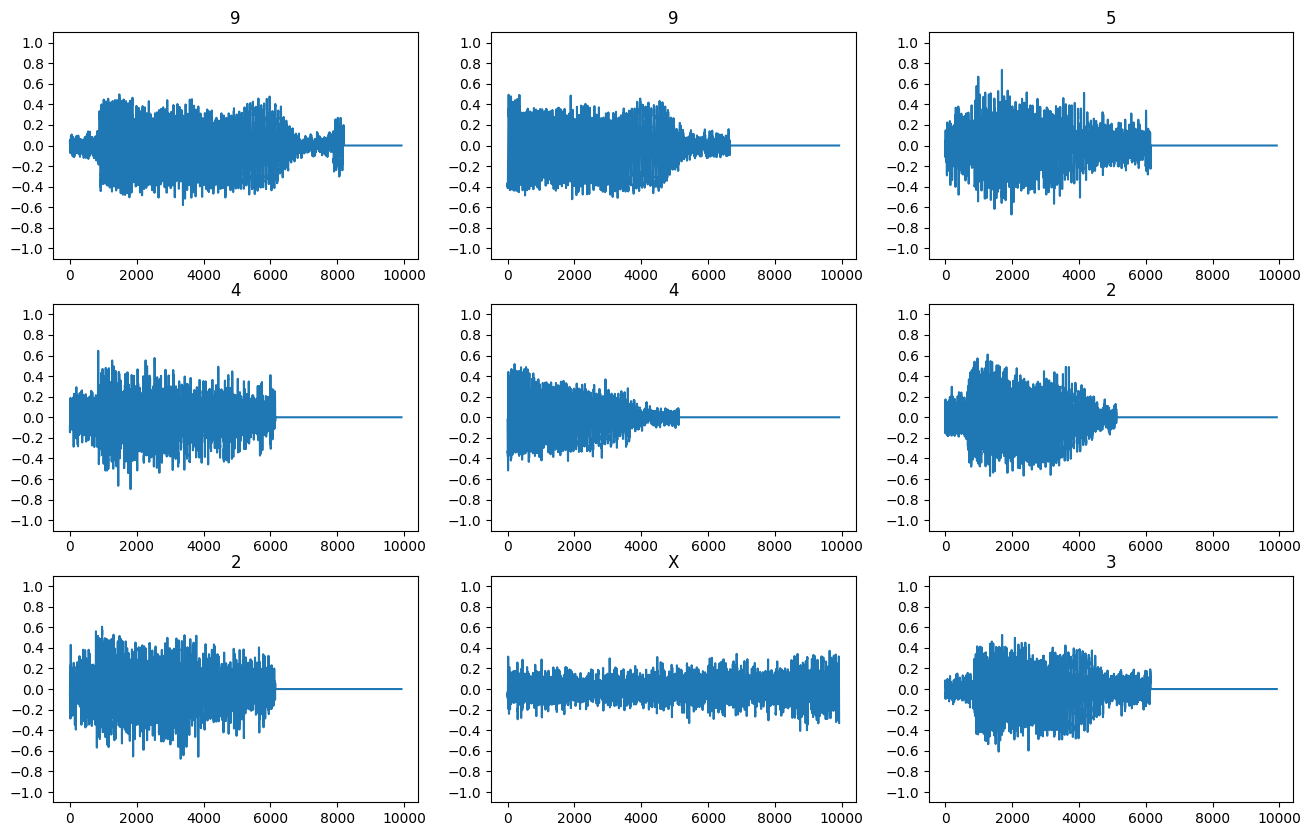

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [ ]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
# test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

# train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
# val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
# test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (76, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
11/11 [==============================] - 3s 110ms/step - loss: 2.1847 - accuracy: 0.2159 - val_loss: 1.6008 - val_accuracy: 0.5625
Epoch 2/10
11/11 [==============================] - 1s 89ms/step - loss: 1.2488 - accuracy: 0.7045 - val_loss: 0.4680 - val_accuracy: 0.9375
Epoch 3/10
11/11 [==============================] - 1s 84ms/step - loss: 0.7269 - accuracy: 0.8125 - val_loss: 0.3194 - val_accuracy: 0.9375
Epoch 4/10
11/11 [==============================] - 1s 123ms/step - loss: 0.3417 - accuracy: 0.8864 - val_loss: 0.0981 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 143ms/step - loss: 0.2016 - accuracy: 0.9659 - val_loss: 0.0887 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 1s 98ms/step - loss: 0.1125 - accuracy: 0.9716 - val_loss: 0.0860 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 1s 82ms/step - loss: 0.1258 - accuracy: 0.9659 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 8/10

Text(0, 0.5, 'Accuracy [%]')

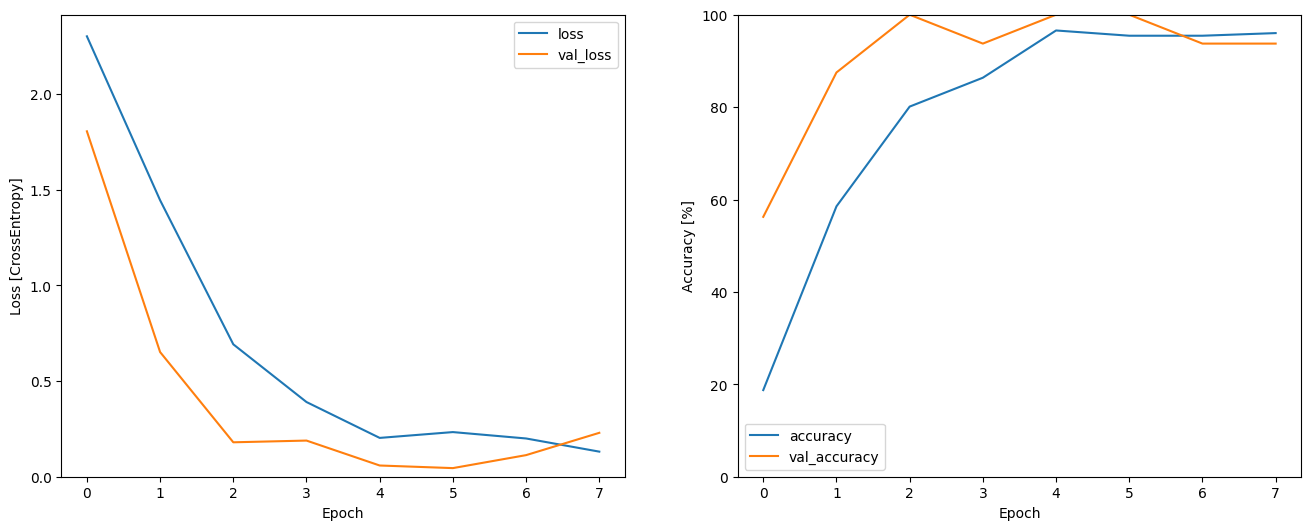

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Testing the model

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

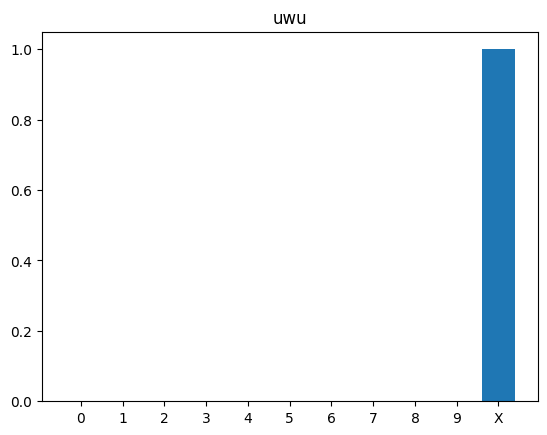

In [ ]:
x = './data/X/2.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=9922,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'X']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('uwu')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 9922], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=9922,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

export = ExportModel(model)
tf.saved_model.save(export, "saved")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
!zip -r model.zip saved

In [ ]:
!unzip model.zip

In [ ]:
import tensorflow as tf
model = tf.saved_model.load("saved")
pred = model('./data/X/1.wav')
pred['class_ids'].numpy()[0]

10

# Designing decaptcha

In [ ]:
!pip install noisereduce

In [ ]:
import noisereduce as nr
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from IPython.display import Audio, display
import soundfile as sf
import tensorflow as tf
import io
import requests

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_segments(y, sr, segments, threshold):
    filtered_segments = []
    for segment in segments:

        duration = (segment[1] - segment[0]) / sr
        if duration > 0.85:
            mid_point = (segment[0] + segment[1]) // 2
            segment1 = (segment[0], mid_point)
            segment2 = (mid_point, segment[1])

            max_amplitude1 = np.max(np.abs(y[segment1[0]:segment1[1]]))
            if max_amplitude1 > threshold:
                filtered_segments.append(segment1)

            max_amplitude2 = np.max(np.abs(y[segment2[0]:segment2[1]]))
            if max_amplitude2 > threshold:
                filtered_segments.append(segment2)
        else:
            max_amplitude = np.max(np.abs(y[segment[0]:segment[1]]))
            if max_amplitude > threshold:
                filtered_segments.append(segment)

    return filtered_segments

def separate_audio(path):
    y, sr = librosa.load(path, sr=None)
    oy = np.copy(y)

    y = nr.reduce_noise(y=y, sr=sr)
    y = butter_bandpass_filter(y, 200, 300, sr)
    y = np.where(np.abs(y) < 0.01, 0, y)

    segments = librosa.effects.split(y, hop_length=1024)
    segments = filter_segments(y, sr, segments, 0.025)

    segments_audio = []
    for segment in segments:
        segments_audio.append(oy[segment[0]:segment[1]])

    return segments_audio, sr, segments

def separate_audio_url(url, cookies=None):
    response = requests.get(url, cookies=cookies)
    audio_data = response.content
    y, sr = librosa.load(io.BytesIO(audio_data), sr=None)
    oy = np.copy(y)

    y = nr.reduce_noise(y=y, sr=sr)
    y = butter_bandpass_filter(y, 200, 300, sr)
    y = np.where(np.abs(y) < 0.01, 0, y)

    segments = librosa.effects.split(y, hop_length=1024)
    segments = filter_segments(y, sr, segments, 0.025)

    segments_audio = []
    for segment in segments:
        segments_audio.append(oy[segment[0]:segment[1]])

    return segments_audio, sr, segments

def preprocess_audio(x):
    desired_length = 9922
    if x.shape[0] < desired_length:
        padding = desired_length - x.shape[0]
        x = tf.pad(x, paddings=[[0, padding]], mode='CONSTANT')
    elif x.shape[0] > desired_length:
        x = x[:desired_length]
    x = tf.reshape(x, shape=(1, -1))
    return x

In [ ]:
URL = 'https://oauth.ccxp.nthu.edu.tw/v1.1/captchaplay.php?id=w8e3vj7ax9ynkuhox0nhhvx5aykyqzqz9xnkawwt'
COOKIE = {'PHPSESSID': 'q7f5ur88t643rsl70lhupn09k3'}
Y, sr, _ = separate_audio_url(URL, COOKIE)

model = tf.saved_model.load("saved")

answer = []
for audio in Y:
    x = tf.convert_to_tensor(audio, dtype=tf.float32)
    x = preprocess_audio(x)
    pred = model(x)
    answer.append(pred['class_ids'].numpy()[0])

answer = [str(a) for a in answer if a != 10]
answer_string = ''.join(answer)
print(answer_string)

2410


# OpenAI when hire uwu

In [ ]:
!unzip model.zip

In [ ]:
import tensorflow as tf

imported = tf.saved_model.load('saved')
call = imported.__call__.get_concrete_function(tf.TensorSpec(shape=[None, 9922], dtype=tf.float32))
tf.saved_model.save(imported, 'model', signatures=call)

In [ ]:
!zip -r sig_model.zip model

In [ ]:
!unzip sig_model.zip

Archive:  sig_model.zip
   creating: model/
  inflating: model/saved_model.pb    
 extracting: model/fingerprint.pb    
   creating: model/variables/
  inflating: model/variables/variables.index  
  inflating: model/variables/variables.data-00000-of-00001  
   creating: model/assets/


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('model')
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS,
#     tf.lite.OpsSet.SELECT_TF_OPS
# ]
tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
signatures = interpreter.get_signature_list()
print(signatures)

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
!pip install tflite-runtime

In [ ]:
import noisereduce as nr
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, stft
from IPython.display import Audio, display
import soundfile as sf
import io
import requests
import tflite_runtime.interpreter as tflite
import tensorflow as tf

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_segments(y, sr, segments, threshold):
    filtered_segments = []
    for segment in segments:

        duration = (segment[1] - segment[0]) / sr
        if duration > 0.85:
            mid_point = (segment[0] + segment[1]) // 2
            segment1 = (segment[0], mid_point)
            segment2 = (mid_point, segment[1])

            max_amplitude1 = np.max(np.abs(y[segment1[0]:segment1[1]]))
            if max_amplitude1 > threshold:
                filtered_segments.append(segment1)

            max_amplitude2 = np.max(np.abs(y[segment2[0]:segment2[1]]))
            if max_amplitude2 > threshold:
                filtered_segments.append(segment2)
        else:
            max_amplitude = np.max(np.abs(y[segment[0]:segment[1]]))
            if max_amplitude > threshold:
                filtered_segments.append(segment)

    return filtered_segments

def separate_audio(path):
    y, sr = librosa.load(path, sr=None)
    oy = np.copy(y)

    y = nr.reduce_noise(y=y, sr=sr)
    y = butter_bandpass_filter(y, 200, 300, sr)
    y = np.where(np.abs(y) < 0.01, 0, y)

    segments = librosa.effects.split(y, hop_length=1024)
    segments = filter_segments(y, sr, segments, 0.025)

    segments_audio = []
    for segment in segments:
        segments_audio.append(oy[segment[0]:segment[1]])

    return segments_audio, sr, segments

def separate_audio_url(url, cookies=None):
    response = requests.get(url, cookies=cookies)
    audio_data = response.content
    y, sr = librosa.load(io.BytesIO(audio_data), sr=None)
    oy = np.copy(y)

    y = nr.reduce_noise(y=y, sr=sr)
    y = butter_bandpass_filter(y, 200, 300, sr)
    y = np.where(np.abs(y) < 0.01, 0, y)

    segments = librosa.effects.split(y, hop_length=1024)
    segments = filter_segments(y, sr, segments, 0.025)

    segments_audio = []
    for segment in segments:
        segments_audio.append(oy[segment[0]:segment[1]])

    return segments_audio, sr, segments

def preprocess_audio(x):
    desired_length = 9922
    if x.shape[0] < desired_length:
        padding = desired_length - x.shape[0]
        x = np.pad(x, pad_width=((0, padding)), mode='constant')
    elif x.shape[0] > desired_length:
        x = x[:desired_length]
    x = np.reshape(x, newshape=(1, -1))
    return x

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

model = tflite.Interpreter(model_path='model.tflite', num_threads=4)

URL = 'https://oauth.ccxp.nthu.edu.tw/v1.1/captchaplay.php?id=8b1f261696c77a4405c734359e75459bc29fd3ba'
COOKIE = {'PHPSESSID': 'q7f5ur88t643rsl70lhupn09k3'}
Y, sr, _ = separate_audio_url(URL, COOKIE)

answer = []
for audio in Y:
    x = np.asarray(audio)
    x = preprocess_audio(x)
    x = get_spectrogram(x)
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    model.allocate_tensors()
    model.set_tensor(input_details[0]['index'], x)
    model.invoke()
    prediction = model.get_tensor(output_details[0]['index'])
    answer.append(np.argmax(prediction[0]))

answer = [str(a) for a in answer if a != 10]
answer_string = ''.join(answer)
print(answer_string)

9112


In [ ]:
!pip freeze